In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.applications import VGG16
from sklearn.metrics import *
import tensorflow.keras.backend as K
import os
import seaborn as sr
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.regularizers import *

from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import *
from tqdm import tqdm
from Custom_Image_generator import *
from neural_net import build_model,build_and_train
from customized_data_generator import CustomDataGen
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

2022-11-16 21:13:09.247233: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Found 6232 images belonging to 3 classes.
Found 912 images belonging to 4 classes.


In [2]:
def create_base(shape):
    inputs=Input(shape=shape)
    
    # First conv layer
    x = Conv2D(32, (7, 7), padding="same",kernel_regularizer=l2(0.01))(inputs)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    
     # Second conv layer
    x = Conv2D(64, (5, 5), padding = "same",kernel_regularizer=l2(0.01))(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
    
    x = Conv2D(128, (5,5), padding="same",kernel_regularizer=l2(0.01))(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
   
    
    x = Conv2D(96, (5, 5), padding="same",kernel_regularizer=l2(0.01))(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
   
    
    x = Conv2D(96, (3, 3), padding="same",kernel_regularizer=l2(0.01))(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
    
    x = Conv2D(128, (3, 3), padding="same",kernel_regularizer=l2(0.01))(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
#     x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
    
    
#     x = pca()(x)
    outputs= Flatten()(x)
    return Model(inputs, outputs)


### Base model from hyper_space

Hyperspace:
{'activation': 'relu', 'batch_size': 8.0, 'conv_dropout_drop_proba': 0.08485224080050567, 'conv_hiddn_units_mult': 1.7123708608540364, 'conv_kernel_size': 5, 'conv_pool_res_start_idx': 2.0, 'fc_dropout_drop_proba': 0.1620371628635939, 'fc_units_1_mult': 0.9347515593740395, 'first_conv': None, 'l2_weight_reg_mult': 1.408262559065776, 'lr_rate_mult': 0.7705687489240158, 'nb_conv_pool_layers': 6, 'one_more_fc': None, 'optimizer': 'SGD', 'pooling_type': 'max', 'res_conv_kernel_size': 3.0, 'residual': None, 'use_BN': False}


2022-11-16 21:13:10.628516: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-16 21:13:10.629253: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-16 21:13:10.658782: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 21:13:10.658894: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-11-16 21:13:10.658907: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-11-16 21:13:10.659934: I tensorflow/stream_executor/platfor

0
68
(None, 224, 224, 3)
(None, 224, 224, 68)
(None, 112, 112, 68)
1
136
(None, 112, 112, 68)
(None, 112, 112, 136)
(None, 56, 56, 136)
2
272
(None, 56, 56, 136)
(None, 56, 56, 272)
(None, 28, 28, 272)
3
544
(None, 28, 28, 272)
(None, 28, 28, 544)
(None, 14, 14, 544)
4
1088
(None, 14, 14, 544)
(None, 14, 14, 1088)
(None, 7, 7, 1088)
5
2176
(None, 7, 7, 1088)
(None, 7, 7, 2176)
(None, 3, 3, 2176)
(None, 19584)
(None, 934)


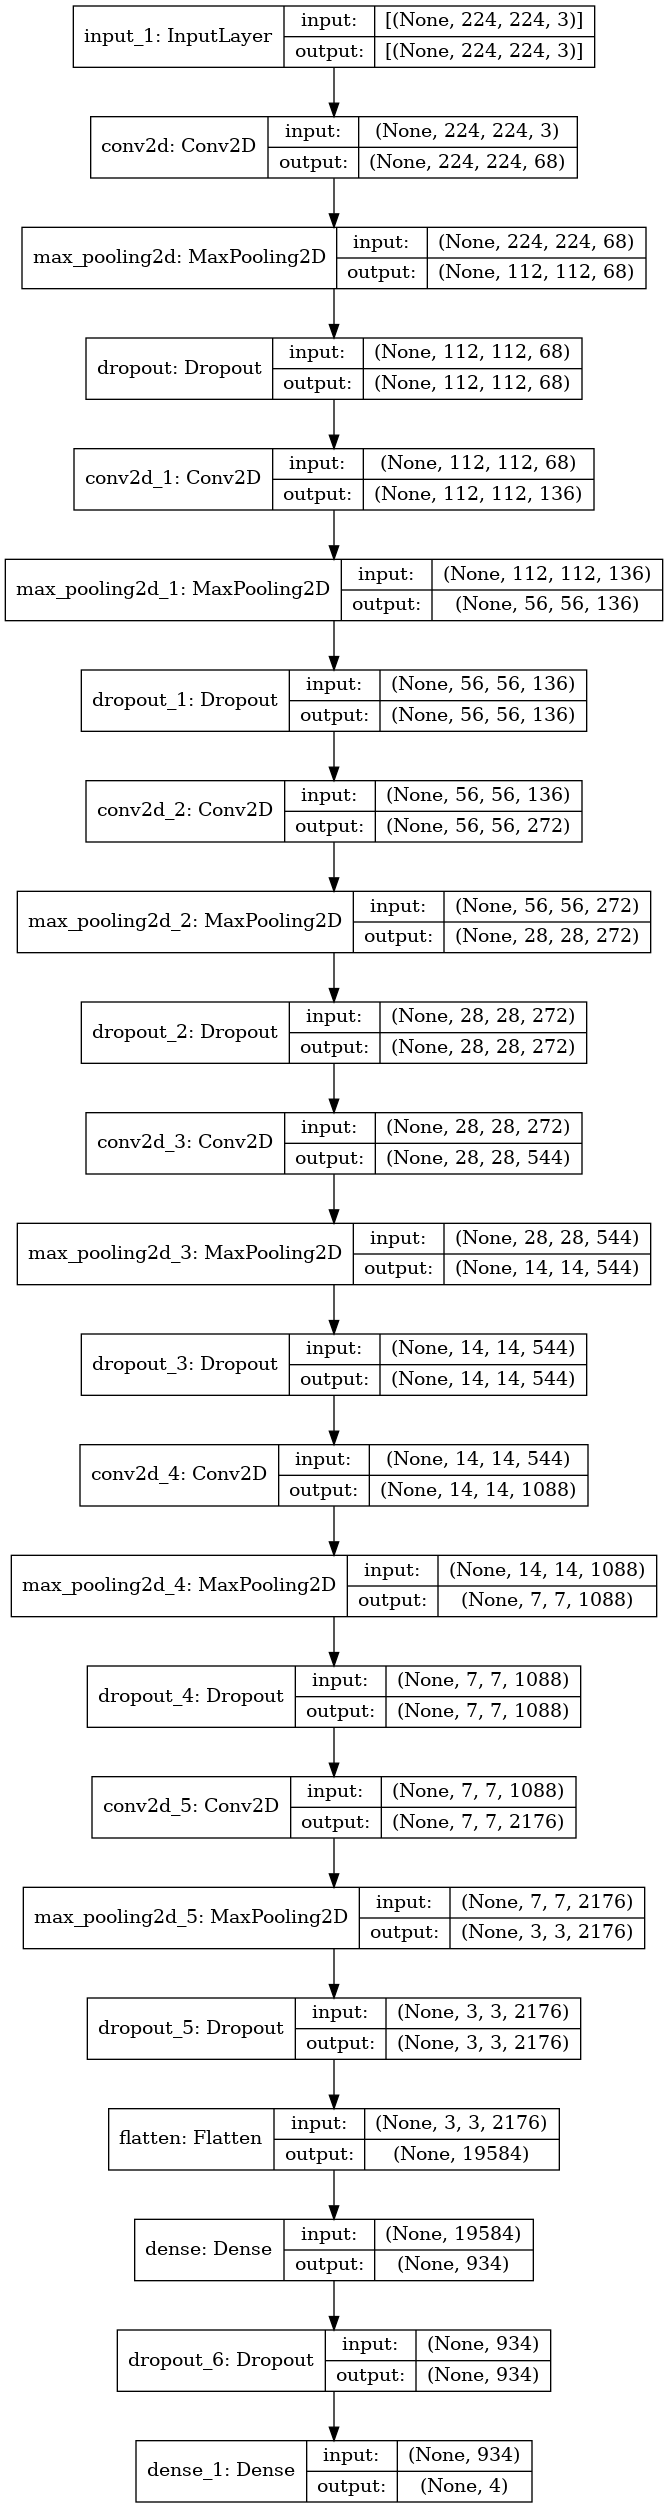

In [3]:
space= {
        "activation": "relu",
        "batch_size": 8.0,
        "conv_dropout_drop_proba": 0.08485224080050567,
        "conv_hiddn_units_mult": 1.7123708608540364,
        "conv_kernel_size": 5,
        "conv_pool_res_start_idx": 2.0,
        "fc_dropout_drop_proba": 0.1620371628635939,
        "fc_units_1_mult": 0.9347515593740395,
        "first_conv": None,
        "l2_weight_reg_mult": 1.408262559065776,
        "lr_rate_mult": 0.7705687489240158,
        "nb_conv_pool_layers": 6,
        "one_more_fc": None,
        "optimizer": "SGD",
        "pooling_type": "max",
        "res_conv_kernel_size": 3.0,
        "residual": None,
        "use_BN": False
    }
base = build_model(space)

plot_model (base,show_shapes=True)

In [4]:

# path= "/media/kashraf/Elements/Dissertation/modelling/hyperopt/intervals/stacked/interv1/weights"
# model1= load_model(os.path.join(path,"8986c_stacked_interv1_V1.h5"))
# base_model = Model(inputs=model1.input,outputs=model1.get_layer("dropout_1").output)
# base_model = Conv2D(64, (5, 5), padding = "same",kernel_regularizer=l2(0.01))(base_model)
# base_model.summary()

In [5]:
# model1.summary()

### PCA layer

In [6]:
class pca(Layer):
    def __init__(self, n_components = 1):
        super().__init__()
        self.g = None
        self.n_components = n_components
        
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'g': self.g,
            'n_components': self.n_components
        })
        return config
    
    @tf.function
    def call(self, X):
        
        m, p, q, n = X.shape
        X_r = tf.transpose(X, perm=[0,3,1,2])
        X_r = tf.reshape(X_r, (-1, p, q))
        if m != None:
            i=0
            if self.g is None:
                self.g = tf.Variable(tf.zeros((m*n, p, self.n_components)))
            
            for x in X_r:
                
                cov = tf.tensordot(x, x, axes=1)
                s, u, v = tf.linalg.svd(cov)
                U1 = u[:, 0:self.n_components]

                x_proj = tf.tensordot(x, U1, axes=1)
                
                self.g[i].assign(x_proj)
                i += 1
            return tf.reshape(self.g, (m, -1, n))
        
        return X[:, :, 0, :]
class pca_mean(Layer):
    def __init__(self, n_components = 1):
        super().__init__()
        self.g = None
        self.n_components = n_components
        
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'g': self.g,
            'n_components': self.n_components
        })
        return config
    
    @tf.function
    def call(self, X):
        m, p, q, n = X.shape
        if m != None:
            i=0
            if self.g is None:
                pca_layer = pca()
                
                self.g = pca_layer(X)
                return tf.reduce_mean(self.g, axis=1)
        
        return X[:, 0, 0, :]

## Custom data generator

In [7]:
path ="/media/kashraf/Elements/Dissertation/data/preprocessed/visual/interval_topos/stacked/"
x_trainfiles = [get_img_label (path, interv,keyword="train")[0] for interv in range(1,6)]
y_train_files = get_img_label (path,1,keyword="train")[1]

x_testfiles = [get_img_label (path, interv,keyword="test")[0] for interv in range(1,6)]
y_test_files = get_img_label (path,1,keyword="test")[1]
print("Number of raining images:",x_trainfiles[0].shape)
print("Number of training labels:",y_train_files.shape)
print("Number of raining images:",x_testfiles[0].shape)
print("Number of training labels:",y_test_files.shape)


Number of raining images: (2345,)
Number of training labels: (2345,)
Number of raining images: (936,)
Number of training labels: (936,)


In [8]:
np.array(x_trainfiles[0]).shape

(2345,)

In [9]:
train_gen = CustomDataGen(x_trainfiles,y_train_files,batch_size=1)
test_gen  = CustomDataGen(x_testfiles,y_test_files,batch_size=1)

In [10]:
test_gen.get_data([1])

([array([[[[1., 1., 1.],
           [1., 1., 1.],
           [1., 1., 1.],
           ...,
           [1., 1., 1.],
           [1., 1., 1.],
           [1., 1., 1.]],
  
          [[1., 1., 1.],
           [1., 1., 1.],
           [1., 1., 1.],
           ...,
           [1., 1., 1.],
           [1., 1., 1.],
           [1., 1., 1.]],
  
          [[1., 1., 1.],
           [1., 1., 1.],
           [1., 1., 1.],
           ...,
           [1., 1., 1.],
           [1., 1., 1.],
           [1., 1., 1.]],
  
          ...,
  
          [[1., 1., 1.],
           [1., 1., 1.],
           [1., 1., 1.],
           ...,
           [1., 1., 1.],
           [1., 1., 1.],
           [1., 1., 1.]],
  
          [[1., 1., 1.],
           [1., 1., 1.],
           [1., 1., 1.],
           ...,
           [1., 1., 1.],
           [1., 1., 1.],
           [1., 1., 1.]],
  
          [[1., 1., 1.],
           [1., 1., 1.],
           [1., 1., 1.],
           ...,
           [1., 1., 1.],
           [1., 

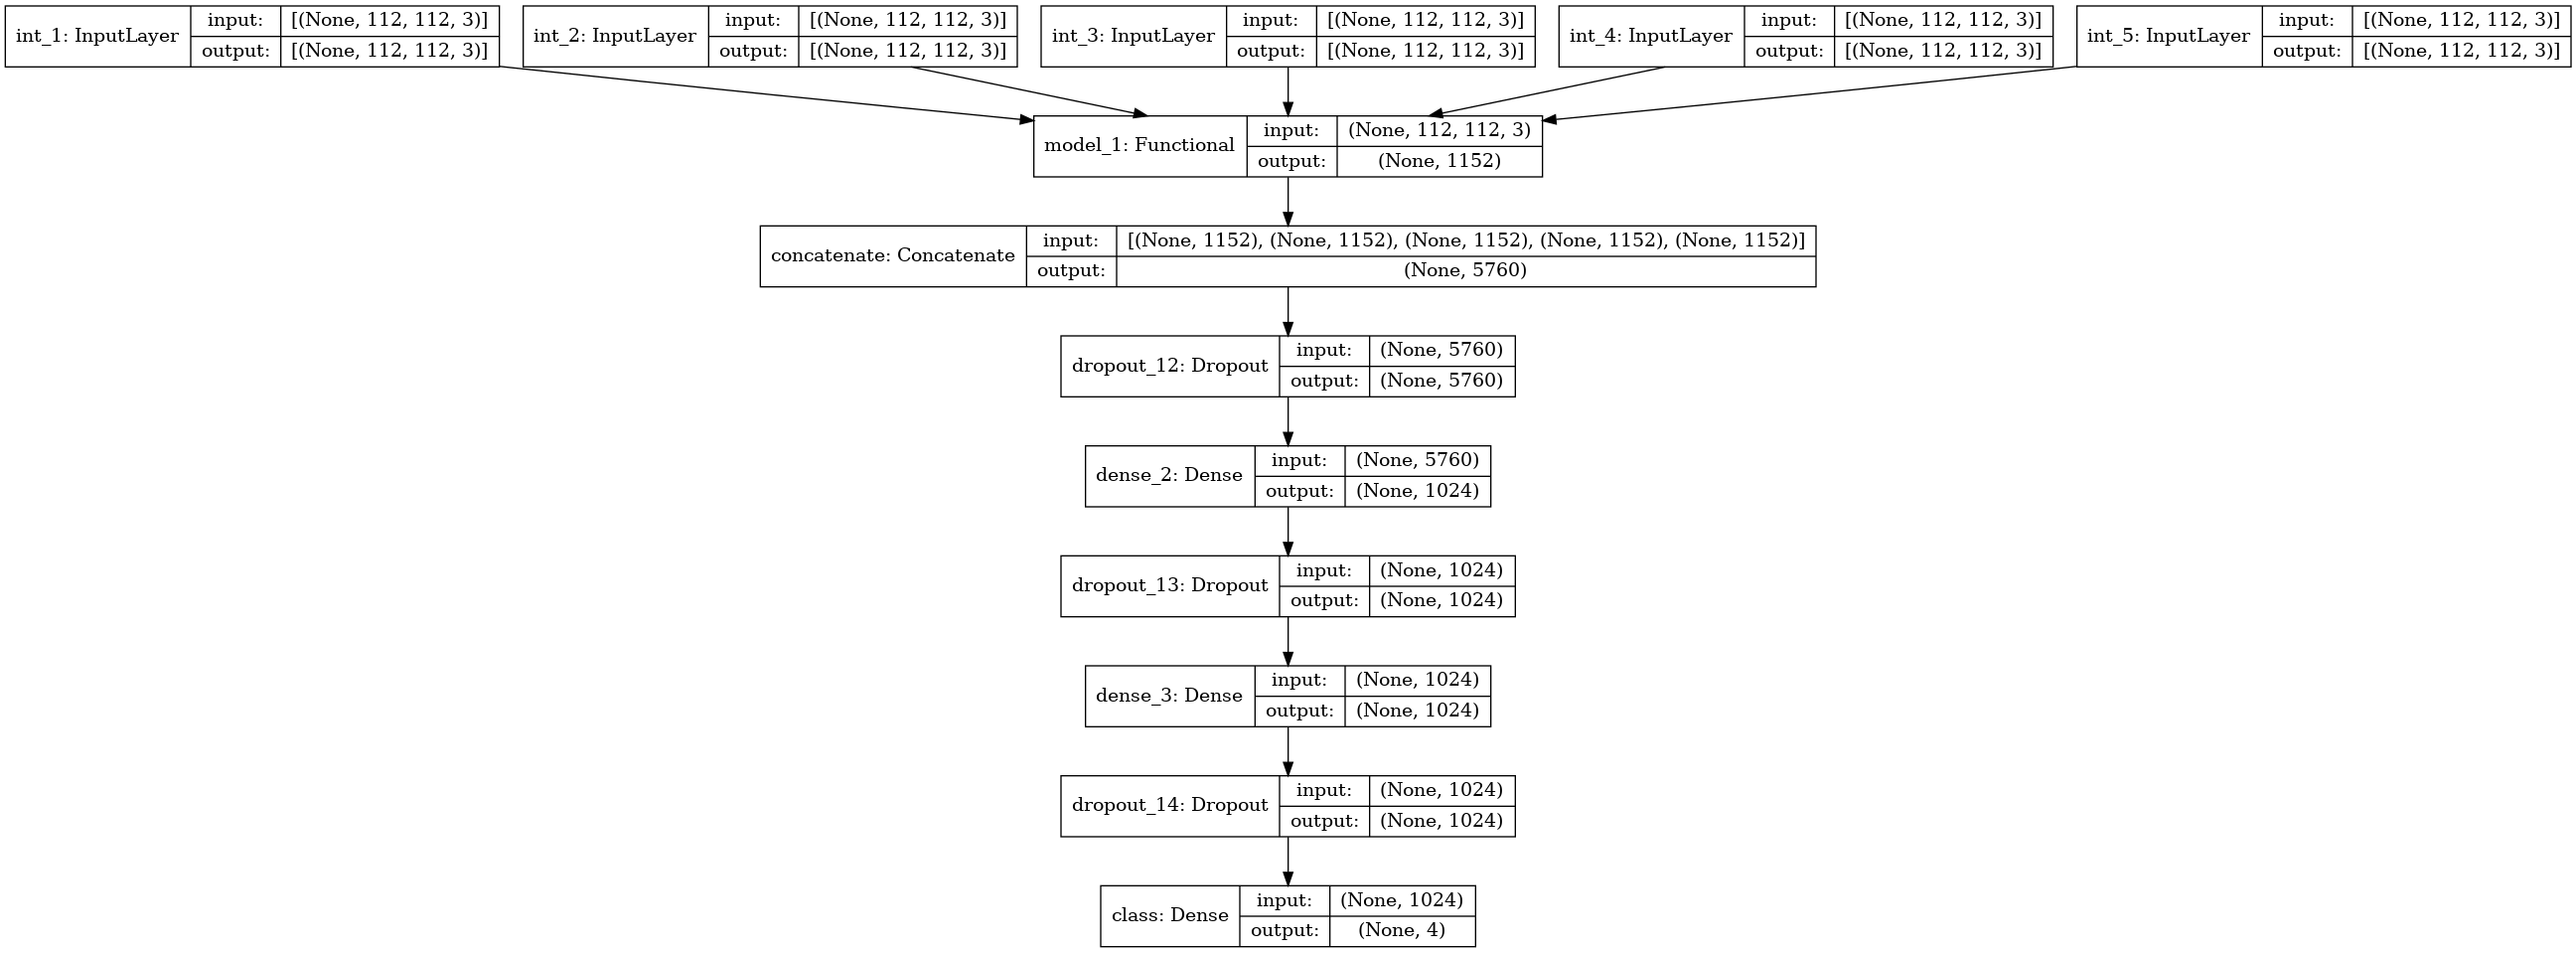

In [11]:
def get_model1():
    img_shape = (112,112,3)
    base_model = create_base(img_shape)
    models = [base_model]*7
    input1 = Input(shape=img_shape,name="int_1")
    input2 = Input(shape=img_shape,name="int_2")
    input3 = Input(shape=img_shape,name="int_3")
    input4 = Input(shape=img_shape,name="int_4")
    input5 = Input(shape=img_shape,name="int_5")
    inputs=[input1,input2,input3,input4,input5]
    
    ys=[models[i](inputs[i]) for i in range(len(inputs))]
    outputs =  tf.keras.layers.concatenate(ys,axis=-1)
    outputs = Dropout(0.4)(outputs)
    dense1 =  Dense(1024)(outputs)
    dense1 =  Dropout(0.3)(dense1)

    dense2 =  Dense(1024)(dense1)
    dense2 =  Dropout(0.3)(dense2)

    # SOFTMAX layer
    fina_out=Dense(4,activation="softmax",name="class")(dense2)

    model =Model(inputs=inputs, outputs=fina_out)
    
    return model
model = get_model1()
plot_model(model,show_shapes=True)

In [12]:
model = get_model1()
weight_dir = "/media/kashraf/Elements/Dissertation/modelling/General/weights/"            
checkpoint = ModelCheckpoint(os.path.join(weight_dir,"Multi_input_CNN_stackedV1.h5"),
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 7,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.000001)

# we put our call backs into a callback list
callbacks = [ checkpoint,reduce_lr]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer =SGD(learning_rate=0.01,momentum=0.9),
              metrics = ['accuracy'])


epochs = 100

history= model.fit(train_gen,validation_data=test_gen,
    epochs=100
)

2022-11-16 21:13:13.204075: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-16 21:13:13.223813: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699850000 Hz


Epoch 1/100


2022-11-16 21:13:14.749875: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-16 21:13:15.099086: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


  45/2345 [..............................] - ETA: 8:55 - loss: nan - accuracy: 0.2357     

2022-11-16 21:13:26.275348: W tensorflow/core/framework/op_kernel.cc:1751] Unknown: IndexError: index 2184 is out of bounds for axis 0 with size 2180
Traceback (most recent call last):

  File "/home/kashraf/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 249, in __call__
    ret = func(*args)

  File "/home/kashraf/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 620, in wrapper
    return func(*args, **kwargs)

  File "/home/kashraf/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 891, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/kashraf/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/data_adapter.py", line 807, in wrapped_generator
    for data in generator_fn():

  File "/home/kashraf/miniconda3/envs/tensorflow/lib/python3.8/site-packages

UnknownError: 2 root error(s) found.
  (0) Unknown:  IndexError: index 2184 is out of bounds for axis 0 with size 2180
Traceback (most recent call last):

  File "/home/kashraf/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 249, in __call__
    ret = func(*args)

  File "/home/kashraf/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 620, in wrapper
    return func(*args, **kwargs)

  File "/home/kashraf/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 891, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/kashraf/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/data_adapter.py", line 807, in wrapped_generator
    for data in generator_fn():

  File "/home/kashraf/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/data_adapter.py", line 933, in generator_fn
    yield x[i]

  File "/media/kashraf/Elements/Dissertation/modelling/General/customized_data_generator.py", line 61, in __getitem__
    x, y = self.get_data(indexes)

  File "/media/kashraf/Elements/Dissertation/modelling/General/customized_data_generator.py", line 41, in get_data
    batch_files = [files[0][batch_indexes],files[1][batch_indexes],

IndexError: index 2184 is out of bounds for axis 0 with size 2180


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
  (1) Unknown:  IndexError: index 2184 is out of bounds for axis 0 with size 2180
Traceback (most recent call last):

  File "/home/kashraf/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 249, in __call__
    ret = func(*args)

  File "/home/kashraf/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 620, in wrapper
    return func(*args, **kwargs)

  File "/home/kashraf/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 891, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/kashraf/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/data_adapter.py", line 807, in wrapped_generator
    for data in generator_fn():

  File "/home/kashraf/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/data_adapter.py", line 933, in generator_fn
    yield x[i]

  File "/media/kashraf/Elements/Dissertation/modelling/General/customized_data_generator.py", line 61, in __getitem__
    x, y = self.get_data(indexes)

  File "/media/kashraf/Elements/Dissertation/modelling/General/customized_data_generator.py", line 41, in get_data
    batch_files = [files[0][batch_indexes],files[1][batch_indexes],

IndexError: index 2184 is out of bounds for axis 0 with size 2180


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_12]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_6851]

Function call stack:
train_function -> train_function


In [ ]:
train_gen.on_epoch_end.

In [ ]:
# x1,x2,x3,x4,x5 = data_gen[0][:,0],data_gen[0][:,1],data_gen[0][:,2],data_gen[0][:,3], data_gen[0][:,4]
# labels=data_gen[1]
# y_train = to_categorical(labels,num_classes=4)
# y_test = to_categorical(x,num_classes=4)

# ensemble_model.fit(
#     x={"int_1":x1,"int_2":x2,"int_3":x3,"int_4":x4,"int_5":x5},
#     y=y_train,
#     validation_data=([x_test[:,0],x_test[:,1],x_test[:,2],
#                       x_test[:,3],x_test[:,4]],y_test),
#     epochs=100,
#     batch_size=32,
# )


In [ ]:
# weight_dir = "/media/kashraf/Elements/Dissertation/modelling/General/weights/"
# ensemble_model.save_weights(os.path.join(weight_dir,"Multi_input_CNN_betaV1.h5"))

### Performance Analysis

In [ ]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


#Confution Matrix and Classification Report
Y_pred =  ensemble_model.predict([data_gen_test[0][:,0],data_gen_test[0][:,1],
                                 data_gen_test[0][:,2],data_gen_test[0][:,3], 
                                 data_gen_test[0][:,4]])
y_pred = np.argmax(Y_pred, axis=1)
y_test = data_gen_test[1]

report= classification_report(y_test,y_pred)

conf=confusion_matrix(y_test,y_pred,normalize="true")
conf_df=pd.DataFrame(conf, index=class_names, columns=class_names)
# print("\nFace  accuracy =",accuracy)
print("\n Classification report: \n",report)
fig=plt.figure(figsize=(15,10))
sr.heatmap(conf_df,annot=True,cmap="Blues")
# plt.title("Confusion matrix")
# plt.savefig(results_path+"Confusion matrix_alpha_gan_&_real.png")
# plt.show()
res_dir=  "/media/kashraf/Elements/Dissertation/modelling/General/results/"
plt.savefig(os.path.join(res_dir,"Confmat_multi_input_CNN_beta_V1.png"))
np.save(os.path.join(res_dir,"Report_multi_input_CNN_beta_V1.npy"),report)
plt.show()